In [ ]:
!pip install keras==2.10.0
!pip install tensorflow==2.10.0
!pip install h5py==3.7.0

In [ ]:
!pip install efficientnet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip /content/drive/MyDrive/car_damage_classification/Data.zip -d /content/drive/MyDrive/car_damage_classification

Archive:  /content/drive/MyDrive/car_damage_classification/Data.zip
   creating: /content/drive/MyDrive/car_damage_classification/Data/
   creating: /content/drive/MyDrive/car_damage_classification/Data/training/
   creating: /content/drive/MyDrive/car_damage_classification/Data/training/damage/
  inflating: /content/drive/MyDrive/car_damage_classification/Data/training/damage/0001.JPEG  
  inflating: /content/drive/MyDrive/car_damage_classification/Data/training/damage/0002.JPEG  
  inflating: /content/drive/MyDrive/car_damage_classification/Data/training/damage/0003.JPEG  
  inflating: /content/drive/MyDrive/car_damage_classification/Data/training/damage/0004.JPEG  
  inflating: /content/drive/MyDrive/car_damage_classification/Data/training/damage/0005.JPEG  
  inflating: /content/drive/MyDrive/car_damage_classification/Data/training/damage/0006.JPEG  
  inflating: /content/drive/MyDrive/car_damage_classification/Data/training/damage/0007.JPEG  
  inflating: /content/drive/MyDrive/ca

In [ ]:
import numpy as np
import pickle
import os
from tqdm import tqdm
import cv2
import pandas as pd
import seaborn as sns
from os import listdir
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from sklearn.utils import shuffle
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import layers
from sklearn.metrics import classification_report,confusion_matrix
import efficientnet.keras as effnet

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
image_size=128
default_image_size = tuple((128, 128))
labels = os.listdir('/content/drive/MyDrive/car_damage_classification/Data/training')
directory_root = '/content/drive/MyDrive/car_damage_classification/Data'
classes = len(labels)
BATCHZ_SIZE=32

In [ ]:
def image_array(dir):
    try:
        img = cv2.imread(dir)
        if img is not None :
            img = cv2.resize(img, default_image_size)
            return img_to_array(img)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for classes_folder in root_dir :
        image_classes_folder_list = listdir(f"/content/drive/MyDrive/car_damage_classification/Data/training")

    for classes_folder in image_classes_folder_list :
            # remove .DS_Store from list
            if classes_folder == ".DS_Store" :
                image_classes_folder_list.remove(classes_folder)

    for i in listdir('/content/drive/MyDrive/car_damage_classification/Data'):
      for  image_classes_folder in image_classes_folder_list:
              print(f"[INFO] Processing { image_classes_folder} ...")
              image_classes_image_list = listdir(f"{directory_root}/{i}/{ image_classes_folder}/")

              for single_image_classes_image in image_classes_image_list :
                  if single_image_classes_image == ".DS_Store" :
                      image_classes_image_list.remove(single_image_classes_image)

              for image in image_classes_image_list[:]:
                  image_directory = f"{directory_root}/{i}/{ image_classes_folder}/{image}"
                  if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or image_directory.endswith(".png") == True or image_directory.endswith(".PNG") == True or image_directory.endswith(".jpeg") == True or image_directory.endswith(".JPEG") == True:
                      image_list.append(image_array(image_directory))
                      label_list.append( image_classes_folder)
      print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing damage ...
[INFO] Processing nodamage ...
[INFO] Image loading completed
[INFO] Processing damage ...
[INFO] Processing nodamage ...
[INFO] Image loading completed


In [ ]:
X = image_list
Y = label_list

In [ ]:
X = np.array(X)

In [ ]:
X, Y = shuffle(X, Y)
print(X.shape)

(2300, 128, 128, 3)


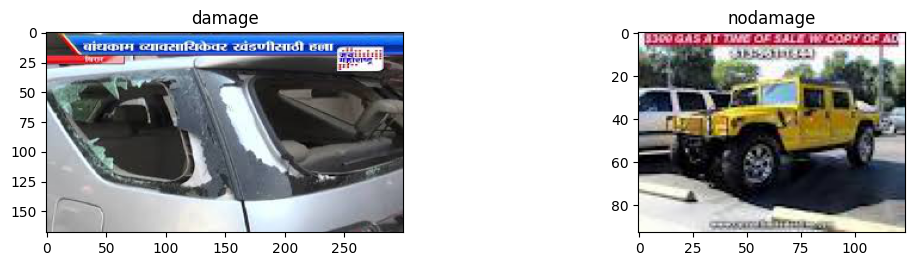

In [ ]:

#Data Visualization
import matplotlib.image as mpimg
plt.figure(figsize = (20, 40))
image_count = 1
BASE_URL = '/content/drive/MyDrive/car_damage_classification/Data/training/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(13, 3, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory)


<Axes: ylabel='count'>

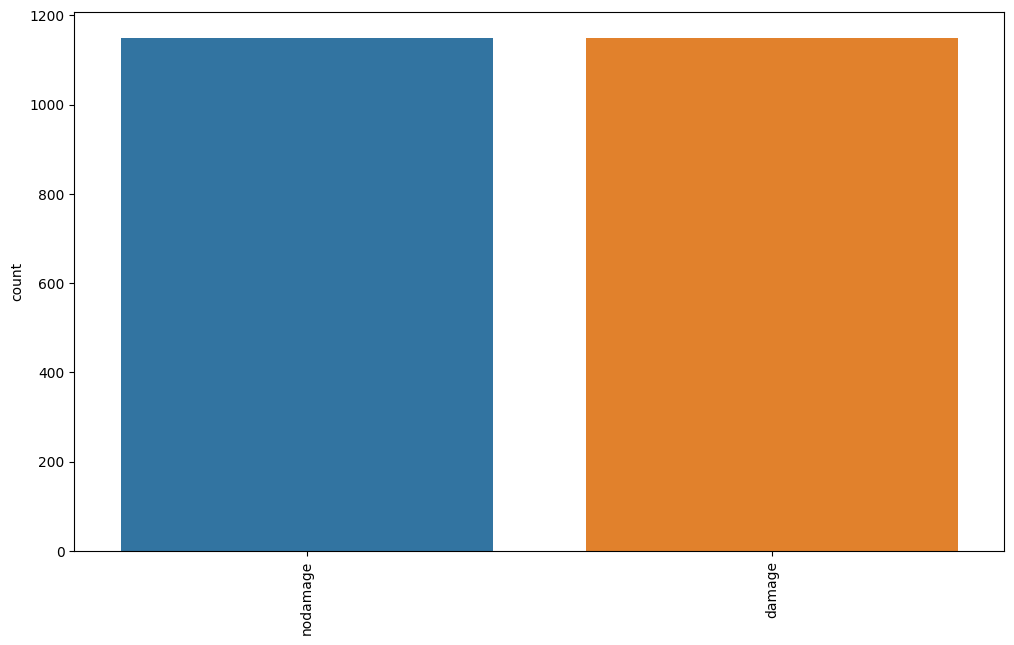

In [ ]:
#count plot
plt.figure(figsize = (12, 7))
plt.xticks(rotation=90)
sns.countplot(x=Y)

In [ ]:
class_labels = LabelBinarizer()
Y = class_labels.fit_transform(Y)
pickle.dump(class_labels,open('/content/drive/MyDrive/car_damage_classification/label_transform.pkl', 'wb'))
n_classes = len(class_labels.classes_)

In [ ]:
cls = len(class_labels.classes_)
print(class_labels.classes_)

['damage' 'nodamage']


In [ ]:
Y = to_categorical(Y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

CNN

In [ ]:
#CNN
depth=3
model = Sequential()
inputShape = (image_size, image_size, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, image_size, image_size)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(cls))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 activation_7 (Activation)   (None, 128, 128, 32)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 42, 42, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 42, 42, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 42, 42, 64)       

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer= "adam", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train,batch_size=BATCHZ_SIZE,validation_data=(X_val, y_val),epochs=5, verbose=1)

Epoch 1/5
59/59 [==============================] - 12s 41ms/step - loss: 0.8067 - accuracy: 0.7118 - val_loss: 0.6968 - val_accuracy: 0.6377
Epoch 2/5
59/59 [==============================] - 2s 30ms/step - loss: 0.4380 - accuracy: 0.7923 - val_loss: 0.4913 - val_accuracy: 0.8019
Epoch 3/5
59/59 [==============================] - 2s 29ms/step - loss: 0.4198 - accuracy: 0.8196 - val_loss: 0.6908 - val_accuracy: 0.7585
Epoch 4/5
59/59 [==============================] - 2s 30ms/step - loss: 0.3732 - accuracy: 0.8465 - val_loss: 0.4925 - val_accuracy: 0.7923
Epoch 5/5
59/59 [==============================] - 2s 31ms/step - loss: 0.3408 - accuracy: 0.8588 - val_loss: 0.6317 - val_accuracy: 0.7198


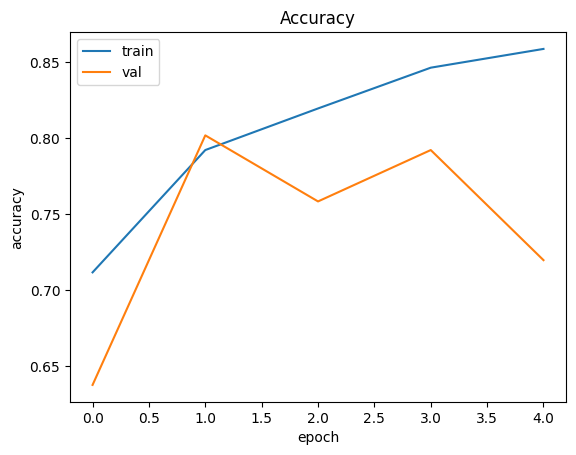

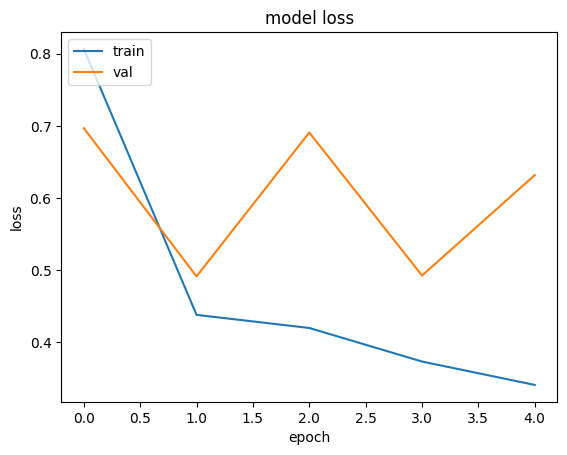

In [ ]:
#accuracy and loss plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()


#loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

8/8 [==============================] - 0s 30ms/step


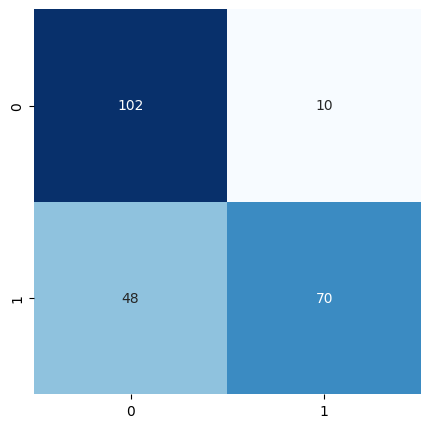

In [ ]:
cmat = confusion_matrix(y_test_new,pred)
plt.figure(figsize=(5,5))
sns.heatmap(cmat, annot = True, cbar = False, cmap='Blues', fmt="d");

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.68      0.91      0.78       112
           1       0.88      0.59      0.71       118

    accuracy                           0.75       230
   macro avg       0.78      0.75      0.74       230
weighted avg       0.78      0.75      0.74       230



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in range(cls):
     prec,recall,_,_ = precision_recall_fscore_support(y_test_new==l,
                                                  pred==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

,class,sensitivity,specificity
0,0,0.593220,0.910714
1,1,0.910714,0.593220


VGG16

In [ ]:
from keras.applications import vgg16
def build_model(backbone):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(cls, activation='softmax'))


    model.compile(
        loss='binary_crossentropy',
        optimizer="adam",
        metrics=['accuracy']
    )

    return model

In [ ]:
vgg_model = vgg16.VGG16(weights="imagenet",
                        include_top=False,
                        input_shape=(image_size,image_size,3))

base_model = vgg16.VGG16
trainable_layers = 4

base_model = base_model(weights="imagenet", include_top=False, input_shape=(image_size,image_size,3))

for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False


model = build_model(base_model)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_13 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14,717,762
Trainable params: 7,081,474
N

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,batch_size=BATCHZ_SIZE,validation_data=(X_val, y_val),epochs=5, verbose=1)

Epoch 1/5
59/59 [==============================] - 10s 120ms/step - loss: 0.4084 - accuracy: 0.8223 - val_loss: 0.4207 - val_accuracy: 0.8696
Epoch 2/5
59/59 [==============================] - 3s 59ms/step - loss: 0.2838 - accuracy: 0.8808 - val_loss: 0.8029 - val_accuracy: 0.7681
Epoch 3/5
59/59 [==============================] - 3s 59ms/step - loss: 0.2037 - accuracy: 0.9238 - val_loss: 3.5014 - val_accuracy: 0.6232
Epoch 4/5
59/59 [==============================] - 3s 59ms/step - loss: 0.1882 - accuracy: 0.9238 - val_loss: 0.3209 - val_accuracy: 0.8889
Epoch 5/5
59/59 [==============================] - 4s 61ms/step - loss: 0.1166 - accuracy: 0.9581 - val_loss: 0.6004 - val_accuracy: 0.7923


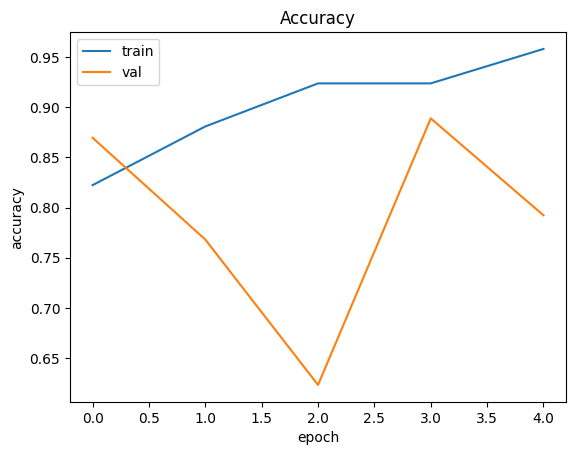

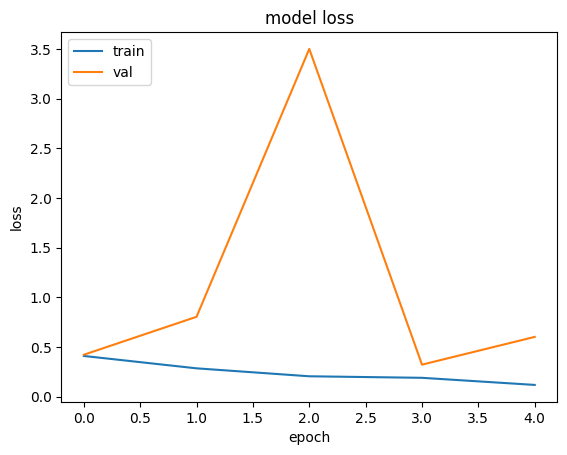

In [ ]:
#accuracy and loss plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()


#loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

8/8 [==============================] - 1s 153ms/step


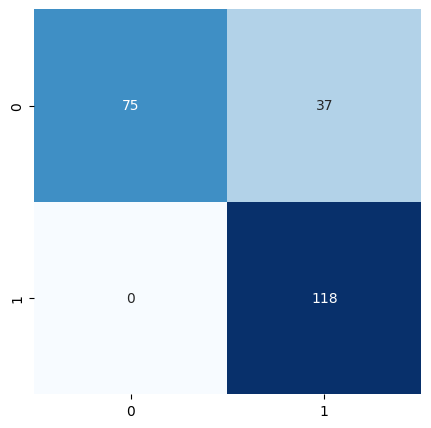

In [ ]:
cmat = confusion_matrix(y_test_new,pred)
plt.figure(figsize=(5,5))
sns.heatmap(cmat, annot = True, cbar = False, cmap='Blues', fmt="d");

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80       112
           1       0.76      1.00      0.86       118

    accuracy                           0.84       230
   macro avg       0.88      0.83      0.83       230
weighted avg       0.88      0.84      0.83       230



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in range(cls):
     prec,recall,_,_ = precision_recall_fscore_support(y_test_new==l,
                                                  pred==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

,class,sensitivity,specificity
0,0,1.000000,0.669643
1,1,0.669643,1.000000


Resnet50

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [ ]:
resnet = ResNet50(weights= None, include_top=False, input_shape= X_train.shape[1:])

In [ ]:
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(cls, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,batch_size=BATCHZ_SIZE,validation_data=(X_val, y_val),epochs=5, verbose=1)

Epoch 1/5
59/59 [==============================] - 18s 164ms/step - loss: 1.1320 - accuracy: 0.6286 - val_loss: 10.8030 - val_accuracy: 0.5700
Epoch 2/5
59/59 [==============================] - 7s 125ms/step - loss: 0.7408 - accuracy: 0.6656 - val_loss: 0.7248 - val_accuracy: 0.5169
Epoch 3/5
59/59 [==============================] - 7s 127ms/step - loss: 0.6772 - accuracy: 0.7198 - val_loss: 0.7562 - val_accuracy: 0.5556
Epoch 4/5
59/59 [==============================] - 7s 126ms/step - loss: 0.6627 - accuracy: 0.7327 - val_loss: 358.4745 - val_accuracy: 0.5072
Epoch 5/5
59/59 [==============================] - 8s 128ms/step - loss: 0.5959 - accuracy: 0.7654 - val_loss: 0.8404 - val_accuracy: 0.5314


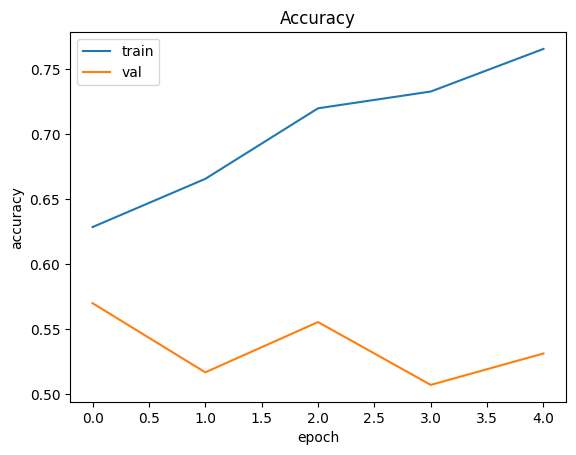

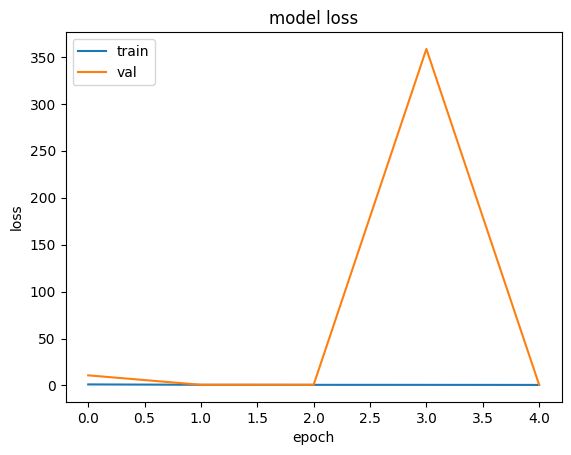

In [ ]:
#accuracy and loss plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()


#loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

8/8 [==============================] - 2s 93ms/step


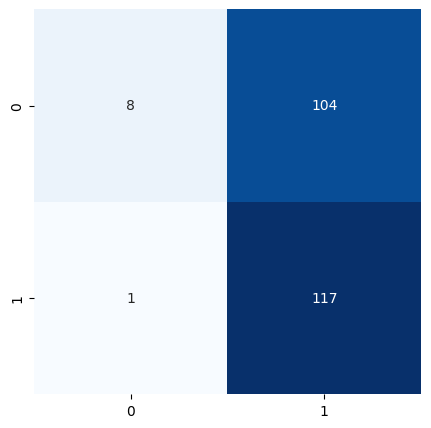

In [ ]:
cmat = confusion_matrix(y_test_new,pred)
plt.figure(figsize=(5,5))
sns.heatmap(cmat, annot = True, cbar = False, cmap='Blues', fmt="d");

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.89      0.07      0.13       112
           1       0.53      0.99      0.69       118

    accuracy                           0.54       230
   macro avg       0.71      0.53      0.41       230
weighted avg       0.70      0.54      0.42       230



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in range(cls):
     prec,recall,_,_ = precision_recall_fscore_support(y_test_new==l,
                                                  pred==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

,class,sensitivity,specificity
0,0,0.991525,0.071429
1,1,0.071429,0.991525


EfficientNetB2

In [ ]:
base_model = effnet.EfficientNetB2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = base_model.output
model = GlobalAveragePooling2D()(model)
model = Dense(cls, activation='softmax')(model)
model = Model(inputs = base_model.input, outputs=model)

31936256/31936256 [==============================] - 0s 0us/step


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 64, 32)   864         ['input_6[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 64, 64, 32)   128         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 64, 64, 32)   0           ['stem_bn[0][0]']          

In [ ]:
history = model.fit(X_train, y_train,batch_size=BATCHZ_SIZE,validation_data=(X_val, y_val),epochs=5, verbose=1)

Epoch 1/5
59/59 [==============================] - 31s 229ms/step - loss: 0.3415 - accuracy: 0.8696 - val_loss: 1.2843 - val_accuracy: 0.5845
Epoch 2/5
59/59 [==============================] - 10s 167ms/step - loss: 0.1674 - accuracy: 0.9442 - val_loss: 0.7193 - val_accuracy: 0.7923
Epoch 3/5
59/59 [==============================] - 9s 154ms/step - loss: 0.1057 - accuracy: 0.9608 - val_loss: 0.4156 - val_accuracy: 0.9034
Epoch 4/5
59/59 [==============================] - 9s 160ms/step - loss: 0.0855 - accuracy: 0.9758 - val_loss: 0.4839 - val_accuracy: 0.8937
Epoch 5/5
59/59 [==============================] - 11s 180ms/step - loss: 0.0432 - accuracy: 0.9871 - val_loss: 0.4087 - val_accuracy: 0.9034


In [ ]:
#model.save('/content/drive/MyDrive/car_damage_classification/Models/EfficientnetB2.h5')

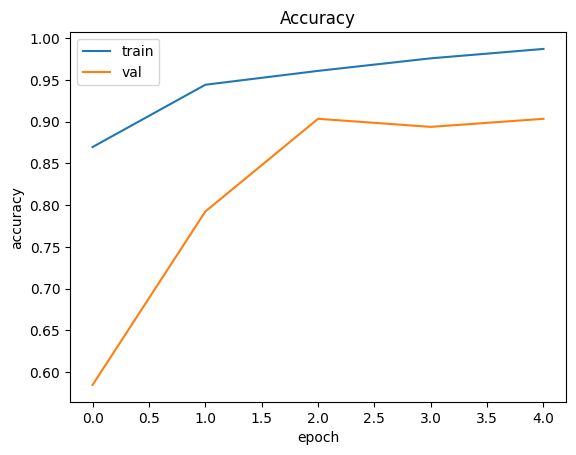

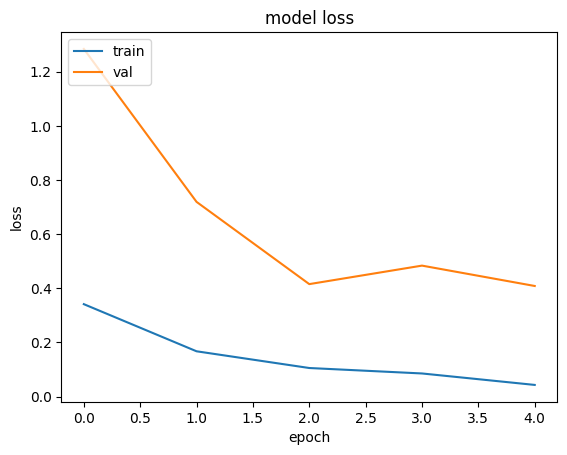

In [ ]:
#accuracy and loss plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()


#loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

8/8 [==============================] - 3s 107ms/step


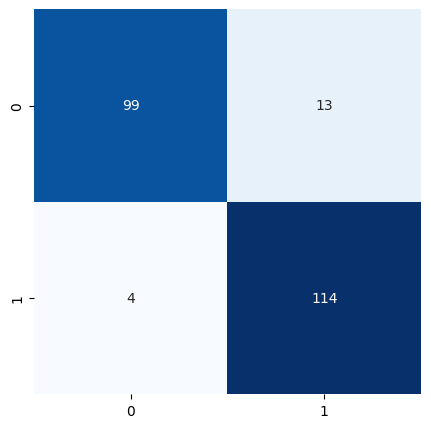

In [ ]:
cmat = confusion_matrix(y_test_new,pred)
plt.figure(figsize=(5,5))
sns.heatmap(cmat, annot = True, cbar = False, cmap='Blues', fmt="d");

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       112
           1       0.90      0.97      0.93       118

    accuracy                           0.93       230
   macro avg       0.93      0.93      0.93       230
weighted avg       0.93      0.93      0.93       230



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in range(cls):
     prec,recall,_,_ = precision_recall_fscore_support(y_test_new==l,
                                                  pred==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

,class,sensitivity,specificity
0,0,0.966102,0.883929
1,1,0.883929,0.966102


Testing

In [ ]:
class_labels = pd.read_pickle(r'/content/drive/MyDrive/car_damage_classification/label_transform.pkl')
label = class_labels.classes_.tolist()
label

['damage', 'nodamage']

In [ ]:
image = cv2.imread('/content/drive/MyDrive/car_damage_classification/Data/validation/damage/0001.JPEG')
image = img_to_array(image)
image = cv2.resize(image, (image_size, image_size))
image = np.array([image])

In [ ]:
image.shape

(1, 128, 128, 3)

In [ ]:
model =load_model('/content/drive/MyDrive/car_damage_classification/Models/EfficientnetB2.h5')
prediction=model.predict(image)
print(prediction)
print(max(prediction[0]))

1/1 [==============================] - 3s 3s/step
[[9.9910200e-01 8.9798676e-04]]
0.999102


In [ ]:
pred_= prediction[0]
pred=[]
for ele in pred_:
  pred.append(ele)

In [ ]:
maxi_ele = max(pred)
idx = pred.index(maxi_ele)
final_class=label
class_name= final_class[idx]
print("Predicted Class Is : " + str(class_name))

Predicted Class Is : damage
